In [69]:
import sys
import os
import scipy.ndimage as nd
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure as sk
from utils import utils
plt.style.use('ggplot')

In [70]:
from torch.autograd import Variable
from torchvision import datasets
from torchvision import transforms as tfs
from torch.utils import data

import torch

#### Load datasets

In [3]:
imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomAffine(0., scale=(0.5, 1.), fillcolor=0),
                                                           tfs.Resize((16, 16)),
                                                           tfs.Grayscale(1)]))

data_loader = data.DataLoader(imagenet_data, batch_size=4, shuffle=True)

(<PIL.Image.Image image mode=L size=16x16 at 0x7FE5A45C4908>, 0)
(<PIL.Image.Image image mode=L size=16x16 at 0x7FE5A44C7198>, 0)
(<PIL.Image.Image image mode=L size=16x16 at 0x7FE5A44910B8>, 0)
(<PIL.Image.Image image mode=L size=16x16 at 0x7FE5A44BCD68>, 0)
(<PIL.Image.Image image mode=L size=16x16 at 0x7FE5A4408710>, 0)


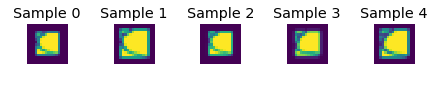

In [4]:
fig = plt.figure()

for i in range(len(imagenet_data)):
    sample = imagenet_data[i + 10]
    print(sample)
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    plt.imshow(np.asarray(sample[0]))
    # print(np.asarray(sample[0]))
    ax.set_title('Sample {}'.format(i))
    ax.axis('off')

    if i == 4:
        plt.show()
        break

#### Define generator & GAN

In [5]:
from models.generator import _G
from models.discriminator import _D
from models.gan import GAN

In [ ]:
import time
import pickle

transforms = [tfs.RandomAffine(0, scale=(0.3, 1.)),
              tfs.Resize((112, 112)),
              tfs.Grayscale(1),
              tfs.ToTensor()]

gan = GAN(epochs=100, input_h_w=112, data_path='data/png_clasificados/',
          transforms=transforms)
gan.train()
print("Training finished!")

# visualize learned generator
gan.visualize_results(gan.epoch)


In [ ]:
from IPython.display import Image

with open('/tmp/GAN_epochs.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

#### Process type of vessels for classification

In [ ]:
df = utils.create_df_from_files()
destination = "data/perfiles_CATA/png_clasificados/"
path = "data/perfiles_CATA/png"
utils.create_folder_pytorch_format(df, destination, path)

#### Build and train classifier

In [14]:
imagenet_data = datasets.ImageFolder('data/png_clasificados/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           # tfs.RandomAffine(0, scale=(0.5, 1.), fillcolor=0),
                                                           tfs.Resize((16, 16)),
                                                           tfs.Grayscale(1),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))

#data_loader = data.DataLoader(imagenet_data, batch_size=64, shuffle=True)

In [15]:
len(imagenet_data.samples), round(1133*0.2), round(1133*0.8)

(1133, 227, 906)

#### Random split or stratified

In [16]:
splits = utils.random_split(imagenet_data, [227, 906])

train_loader = data.DataLoader(splits[1], batch_size=32, shuffle=True)
val_loader = data.DataLoader(splits[0], batch_size=32, shuffle=True)


In [146]:
imagenet_data_train = datasets.ImageFolder('data/png_class_train/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           # tfs.RandomAffine(0, scale=(0.5, 1.), fillcolor=0),
                                                           tfs.Resize((16, 16)),
                                                           tfs.Grayscale(1),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))

imagenet_data_val = datasets.ImageFolder('data/png_class_test/',
                                     transform=tfs.Compose([tfs.RandomHorizontalFlip(p=0.7),
                                                           # tfs.RandomAffine(0, scale=(0.5, 1.), fillcolor=0),
                                                           tfs.Resize((16, 16)),
                                                           tfs.Grayscale(1),
                                                           tfs.ToTensor(),
                                                           tfs.Normalize((0.5,), (0.5,))]))

train_loader = data.DataLoader(imagenet_data_train, batch_size=64, shuffle=True)
val_loader = data.DataLoader(imagenet_data_val, batch_size=64, shuffle=True)

In [72]:
import torch.optim as optim
from torch import nn
from models.classifier import _C
import visdom
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import CategoricalAccuracy, Loss
import torch.nn.functional as F

In [158]:
C =_C(input_h_w=16)
C = C.cuda()
criterion = nn.CrossEntropyLoss().cuda()
C_optimizer = optim.Adam(C.parameters(), lr=0.0002, betas=(0.5, 0.999))

vis = visdom.Visdom()
log_interval = 10
trainer = create_supervised_trainer(C, C_optimizer, F.cross_entropy, device='cuda')
evaluator = create_supervised_evaluator(C, metrics={'accuracy': CategoricalAccuracy(),
                                                     'ce_ll': Loss(F.cross_entropy)},
                                           device='cuda')

train_avg_loss_window = utils.create_plot_window(vis, '#Iterations', 'Loss', 'Training Average Loss')
train_avg_accuracy_window = utils.create_plot_window(vis, '#Iterations', 'Accuracy', 'Training Average Accuracy')
val_avg_loss_window = utils.create_plot_window(vis, '#Epochs', 'Loss', 'Validation Average Loss')
val_avg_accuracy_window = utils.create_plot_window(vis, '#Epochs', 'Accuracy', 'Validation Average Accuracy')


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(train_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Training Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=train_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=train_avg_loss_window, update='append')

@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(engine):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    avg_accuracy = metrics['accuracy']
    avg_nll = metrics['ce_ll']
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(engine.state.epoch, avg_accuracy, avg_nll))
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_accuracy]),
             win=val_avg_accuracy_window, update='append')
    vis.line(X=np.array([engine.state.epoch]), Y=np.array([avg_nll]),
             win=val_avg_loss_window, update='append')

trainer.run(train_loader, max_epochs=200)

Training Results - Epoch: 1  Avg accuracy: 0.22 Avg loss: 2.36
Validation Results - Epoch: 1  Avg accuracy: 0.25 Avg loss: 2.36
Training Results - Epoch: 2  Avg accuracy: 0.54 Avg loss: 2.28
Validation Results - Epoch: 2  Avg accuracy: 0.52 Avg loss: 2.29
Training Results - Epoch: 3  Avg accuracy: 0.70 Avg loss: 2.19
Validation Results - Epoch: 3  Avg accuracy: 0.72 Avg loss: 2.19
Training Results - Epoch: 4  Avg accuracy: 0.77 Avg loss: 2.02
Validation Results - Epoch: 4  Avg accuracy: 0.75 Avg loss: 2.03
Training Results - Epoch: 5  Avg accuracy: 0.82 Avg loss: 1.86
Validation Results - Epoch: 5  Avg accuracy: 0.82 Avg loss: 1.88
Training Results - Epoch: 6  Avg accuracy: 0.80 Avg loss: 1.79
Validation Results - Epoch: 6  Avg accuracy: 0.81 Avg loss: 1.82
Training Results - Epoch: 7  Avg accuracy: 0.85 Avg loss: 1.74
Validation Results - Epoch: 7  Avg accuracy: 0.86 Avg loss: 1.77
Training Results - Epoch: 8  Avg accuracy: 0.85 Avg loss: 1.73
Validation Results - Epoch: 8  Avg accura

Validation Results - Epoch: 64  Avg accuracy: 0.85 Avg loss: 1.68
Training Results - Epoch: 65  Avg accuracy: 0.97 Avg loss: 1.56
Validation Results - Epoch: 65  Avg accuracy: 0.85 Avg loss: 1.68
Training Results - Epoch: 66  Avg accuracy: 0.97 Avg loss: 1.57
Validation Results - Epoch: 66  Avg accuracy: 0.84 Avg loss: 1.68
Training Results - Epoch: 67  Avg accuracy: 0.98 Avg loss: 1.56
Validation Results - Epoch: 67  Avg accuracy: 0.86 Avg loss: 1.67
Training Results - Epoch: 68  Avg accuracy: 0.96 Avg loss: 1.57
Validation Results - Epoch: 68  Avg accuracy: 0.84 Avg loss: 1.69
Training Results - Epoch: 69  Avg accuracy: 0.98 Avg loss: 1.56
Validation Results - Epoch: 69  Avg accuracy: 0.86 Avg loss: 1.67
Training Results - Epoch: 70  Avg accuracy: 0.98 Avg loss: 1.56
Validation Results - Epoch: 70  Avg accuracy: 0.85 Avg loss: 1.68
Training Results - Epoch: 71  Avg accuracy: 0.98 Avg loss: 1.56
Validation Results - Epoch: 71  Avg accuracy: 0.86 Avg loss: 1.68
Training Results - Epoch

Validation Results - Epoch: 127  Avg accuracy: 0.84 Avg loss: 1.69
Training Results - Epoch: 128  Avg accuracy: 0.98 Avg loss: 1.56
Validation Results - Epoch: 128  Avg accuracy: 0.86 Avg loss: 1.70
Training Results - Epoch: 129  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 129  Avg accuracy: 0.87 Avg loss: 1.69
Training Results - Epoch: 130  Avg accuracy: 0.97 Avg loss: 1.56
Validation Results - Epoch: 130  Avg accuracy: 0.85 Avg loss: 1.68
Training Results - Epoch: 131  Avg accuracy: 0.90 Avg loss: 1.61
Validation Results - Epoch: 131  Avg accuracy: 0.78 Avg loss: 1.73
Training Results - Epoch: 132  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 132  Avg accuracy: 0.86 Avg loss: 1.68
Training Results - Epoch: 133  Avg accuracy: 0.98 Avg loss: 1.56
Validation Results - Epoch: 133  Avg accuracy: 0.85 Avg loss: 1.68
Training Results - Epoch: 134  Avg accuracy: 0.97 Avg loss: 1.57
Validation Results - Epoch: 134  Avg accuracy: 0.84 Avg loss: 1.71
Training 

Training Results - Epoch: 190  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 190  Avg accuracy: 0.87 Avg loss: 1.68
Training Results - Epoch: 191  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 191  Avg accuracy: 0.87 Avg loss: 1.68
Training Results - Epoch: 192  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 192  Avg accuracy: 0.87 Avg loss: 1.68
Training Results - Epoch: 193  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 193  Avg accuracy: 0.85 Avg loss: 1.69
Training Results - Epoch: 194  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 194  Avg accuracy: 0.88 Avg loss: 1.67
Training Results - Epoch: 195  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 195  Avg accuracy: 0.88 Avg loss: 1.67
Training Results - Epoch: 196  Avg accuracy: 0.99 Avg loss: 1.55
Validation Results - Epoch: 196  Avg accuracy: 0.86 Avg loss: 1.69
Training Results - Epoch: 197  Avg accuracy: 1.00 Avg loss: 1.55
Validation 

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for data_ in val_loader:
        images, labels = data_
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
        outputs = C(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the .25 test images: %d %%' % (
    100 * correct / total))

In [41]:
c.size()[0]

32

In [131]:
classes =  list(i for i in range(1, 12))
class_correct = list(0. for i in range(11))
class_total = list(0. for i in range(11))
with torch.no_grad():
    for data_ in val_loader:
        images, labels = data_
        images, labels = Variable(images.cuda()), Variable(labels.cuda())
        outputs = C(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        # print(c)
        if c.size()[0] % 64 == 0:
            for i in range(64):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


for i in range(11):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of     1 : 100 %
Accuracy of     2 : 66 %
Accuracy of     3 : 86 %
Accuracy of     4 : 100 %
Accuracy of     5 : 72 %
Accuracy of     6 : 77 %
Accuracy of     7 : 50 %
Accuracy of     8 : 97 %
Accuracy of     9 : 88 %
Accuracy of    10 : 60 %
Accuracy of    11 : 12 %


In [149]:
val_loader.dataset, train_loader.dataset

(Dataset ImageFolder
     Number of datapoints: 226
     Root Location: data/png_class_test/
     Transforms (if any): Compose(
                              RandomHorizontalFlip(p=0.7)
                              Resize(size=(16, 16), interpolation=PIL.Image.BILINEAR)
                              Grayscale(num_output_channels=1)
                              ToTensor()
                              Normalize(mean=(0.5,), std=(0.5,))
                          )
     Target Transforms (if any): None, Dataset ImageFolder
     Number of datapoints: 907
     Root Location: data/png_class_train/
     Transforms (if any): Compose(
                              RandomHorizontalFlip(p=0.7)
                              Resize(size=(16, 16), interpolation=PIL.Image.BILINEAR)
                              Grayscale(num_output_channels=1)
                              ToTensor()
                              Normalize(mean=(0.5,), std=(0.5,))
                          )
     Target Transforms 

In [166]:
confusion_window = utils.create_plot_window(vis, 'True Labels', 'Predicted', 'Confusion Matrix')

confusion_matrix = torchnet.meter.ConfusionMeter(11, normalized=True)
for ii, data_ in enumerate(val_loader):
    input_, label = data_
    val_input = Variable(input_).cuda()
    val_label = Variable(label.type(torch.LongTensor)).cuda()
    score = C(val_input)
    confusion_matrix.add(score.data.squeeze(), label.type(torch.LongTensor))
print(confusion_matrix.conf)
vis.heatmap(confusion_matrix.value(), win=confusion_window)

[[ 6  0  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  1  0  0  0  0  2  0  1]
 [ 0  0 21  0  0  0  0  4  0  0  0]
 [ 0  0  0 11  0  0  0  0  0  0  0]
 [ 0  0  0  0 12  1  0  0  1  1  0]
 [ 0  0  0  0  0  9  0  1  0  0  0]
 [ 0  0  0  0  0  1  1  0  0  0  0]
 [ 0  0  2  0  0  0  0 71  1  0  0]
 [ 1  1  0  0  1  0  0  0 53  1  1]
 [ 0  0  0  0  0  0  0  0  2  3  0]
 [ 1  0  0  0  2  1  0  0  4  0  2]]


'window_364a32d62656a8'